# Genetic Design

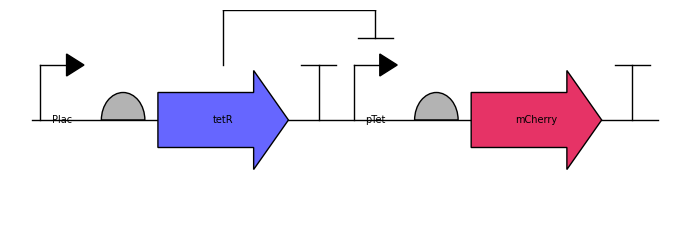

In [8]:
%matplotlib inline

import dnaplotlib as dpl
from matplotlib import pyplot as plt

dr = dpl.DNARenderer()
renderers = dr.SBOL_part_renderers()

# Input TU: Plac → TetR
plac = {'type':'Promoter','fwd':True,'opts':{'label':'Plac'}}
rbs1 = {'type':'RBS','fwd':True}
tetR = {'type':'CDS','fwd':True,'opts':{'label':'tetR','color':[0.4,0.4,1.0]}}
term1 = {'type':'Terminator','fwd':True}

# Output TU: pTet → mCherry
ptet = {'type':'Promoter','fwd':True,'opts':{'label':'pTet'}}
rbs2 = {'type':'RBS','fwd':True}
mcherry = {'type':'CDS','fwd':True,'opts':{'label':'mCherry','color':[0.9,0.2,0.4]}}
term2 = {'type':'Terminator','fwd':True}

design = [
    plac, rbs1, tetR, term1,
    ptet, rbs2, mcherry, term2,
]

regs = [
    {'type':'Repression','from_part':tetR, 'to_part':ptet}
]

fig, ax = plt.subplots(figsize=(7, 2.5))
start, end = dr.renderDNA(
    ax=ax,
    parts=design,
    regs=regs,
    part_renderers=renderers,
    reg_renderers=dr.std_reg_renderers(),
)

ax.set_xlim(start - 5, end + 5)
ax.set_ylim(-20, 20)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Design decisions:
- The lac promoter (Plac) requires the LacI repressor for proper OFF-state function.
- This design assumes the host strain provides LacI inherently (e.g., lacI on the chromosome).
- If LacI is not present in the chosen host, LacI must be added to the plasmid seperately.

# Constructing The Linear Fragment

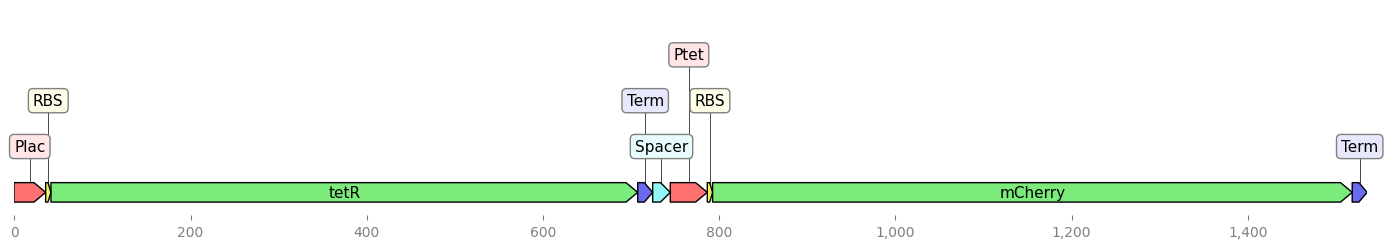

Fragment length: 1536 bp


In [9]:
%matplotlib inline

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt

Plac = "TTTACACTTTATGCTTCCGGCTCGTATAATGTGTGG" # lac promoter
RBS = "AGGAGG" # B0034 ribosome binding site
tetR_CDS = "ATG" + "A"*660 + "TGA" # tetR ~ 221 aa
Term = "TTATTTATTTATTTAGG" # B0015-like terminator
Spacer = "G"*20 # insulation spacer
Ptet = "TCCCTATCAGTGATAGAGATTGACATCCCTATCAGTGATAGA" # Ptet promoter
mCherry = "ATG" + "C"*720 + "TAA" # reporter ~ 240 aa

fragment_seq = Seq(
    Plac + RBS + tetR_CDS + Term +
    Spacer +
    Ptet + RBS + mCherry + Term
)

record = SeqRecord(
    fragment_seq,
    id="Linear_Synth_Inverter_Fragment",
    description="Ordered fragment containing Plac–tetR and Ptet–mCherry"
)

record.features = [
    SeqFeature(FeatureLocation(0, len(Plac)), type="promoter", qualifiers={"label": ["Plac"]}),
    SeqFeature(FeatureLocation(len(Plac), len(Plac) + len(RBS)), type="RBS", qualifiers={"label": ["RBS"]}),
    SeqFeature(FeatureLocation(len(Plac) + len(RBS),
                               len(Plac) + len(RBS) + len(tetR_CDS)),
               type="CDS", qualifiers={"label": ["tetR"]}),
    SeqFeature(FeatureLocation(len(Plac) + len(RBS) + len(tetR_CDS),
                               len(Plac) + len(RBS) + len(tetR_CDS) + len(Term)),
               type="terminator", qualifiers={"label": ["Term"]}),

    # Spacer
    SeqFeature(FeatureLocation(len(Plac) + len(RBS) + len(tetR_CDS) + len(Term),
                               len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer)),
               type="misc_feature", qualifiers={"label": ["Spacer"]}),

    # Output transcription unit
    SeqFeature(FeatureLocation(len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer),
                               len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer) + len(Ptet)),
               type="promoter", qualifiers={"label": ["Ptet"]}),
    SeqFeature(FeatureLocation(
        len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer) + len(Ptet),
        len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer) + len(Ptet) + len(RBS)),
        type="RBS", qualifiers={"label": ["RBS"]}),
    SeqFeature(FeatureLocation(
        len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer) + len(Ptet) + len(RBS),
        len(Plac) + len(RBS) + len(tetR_CDS) + len(Term) + len(Spacer) + len(Ptet) + len(RBS) + len(mCherry)),
        type="CDS", qualifiers={"label": ["mCherry"]}),
    SeqFeature(FeatureLocation(
        len(fragment_seq) - len(Term),
        len(fragment_seq)),
        type="terminator", qualifiers={"label": ["Term"]})
]

feature_colors = {
    "promoter":"#FF7171",
    "RBS":"#F3F35F",
    "CDS":"#7BEB7B",
    "terminator":"#6A6AF1",
    "misc_feature":"#91F8F8"
}

graphic_features = []
for f in record.features:
    name = f.qualifiers["label"][0]
    typ = f.type
    color = feature_colors.get(typ, "#91F8F8")
    graphic_features.append(
        GraphicFeature(
            start=int(f.location.start),
            end=int(f.location.end),
            strand=+1,
            label=name,
            color=color
        )
    )

graphic_record = GraphicRecord(sequence_length=len(record.seq), features=graphic_features)

ax, _ = graphic_record.plot(figure_width=14)
plt.tight_layout()
plt.show()

print("Fragment length:", len(fragment_seq), "bp")


Design decisions:
- The lac promoter (Plac) remains at the 5′ end to preserve IPTG-responsive input control.
- RBS (B0034) was chosen for reliable and strong translation initiation in both transcription units.
- The tetR coding sequence was included as the repression module, enabling inversion by inhibiting downstream reporter expression.
- Terminator (B0015) follows tetR to prevent transcriptional read-through into the second promoter.
- A short neutral spacer was inserted to reduce promoter interference and improve signal insulation.
- The Ptet promoter was placed upstream of the reporter, ensuring its activity is repressed when TetR is present.
- mCherry was selected as the output reporter because its fluorescence provides a clear digital ON/OFF phenotype.
- A second strong terminator was added downstream of mCherry to ensure proper termination and prevent unintended extension into the backbone.

# Simulating Gibson Assembly

Loaded backbone length: 2686
Backbone linearized at EcoRI
Insert total length with overlaps: 1054

Gibson assembly successful
Final construct length: 3680


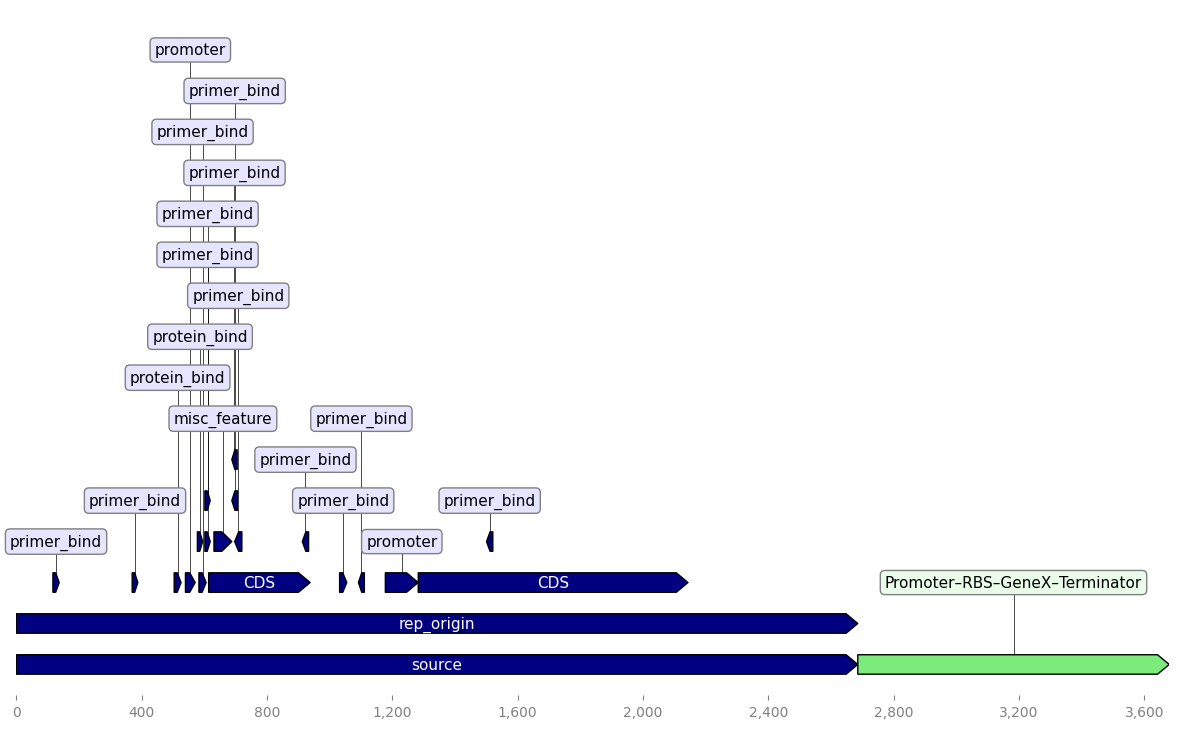

In [10]:
%matplotlib inline

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt

puc19 = SeqIO.read("/Users/dorotheagrkovic/Downloads/notes/data/pUC19.gbk", "genbank")

print("Loaded backbone length:", len(puc19.seq))

ecoRI_site = puc19.seq.find("GAATTC")

if ecoRI_site == -1:
    raise ValueError("EcoRI site not found in pUC19!")

linear_backbone = puc19.seq[ecoRI_site:] + puc19.seq[:ecoRI_site]
print("Backbone linearized at EcoRI")

insert = Seq(
    "TTGACAGCTAGCTCAGTCCTAGGTATAATGCTAGC" + # promoter
    "AGGAGG" + # RBS
    "ATGACCATGATTACGCCAAGCTTGCATGCCTGCAGG" + # start of CDS
    "A" * 900 + # placeholder gene
    "TTATTTATTTATTTAGG" # terminator
)

overlap_left = linear_backbone[:30]
overlap_right = linear_backbone[-30:]

insert_with_overhangs = overlap_right + insert + overlap_left

print("Insert total length with overlaps:", len(insert_with_overhangs))

assembled = linear_backbone + insert

final_construct = SeqRecord(
    assembled,
    id="pUC19_GeneX",
    description="pUC19 with inserted expression cassette via Gibson Assembly"
)

print("\nGibson assembly successful")
print("Final construct length:", len(final_construct.seq))

features = []

for f in puc19.features:
    try:
        features.append(
            GraphicFeature(
                start=int(f.location.start),
                end=int(f.location.end),
                strand=f.location.strand,
                label=f.type
            )
        )
    except:
        pass

features.append(
    GraphicFeature(
        start=len(linear_backbone),
        end=len(linear_backbone) + len(insert),
        strand=+1,
        label="Promoter–RBS–GeneX–Terminator",
        color="#7BEB7B"
    )
)

record = GraphicRecord(sequence_length=len(final_construct.seq), features=features)
ax, _ = record.plot(figure_width=12)
plt.tight_layout()
plt.show()

Design decisions:
- Linearization at EcoRI allows clean insertion without disrupting essential replication elements.
- 30 bp overlaps were added to the ordered insert to make it Gibson-compatible.
- Insert orientation ensures promoter drives GeneX transcription toward backbone origin.
- Assembly simulated by overlap-guided joining and recircularization.